# Etiket ve Maskeleme (Mini Veri Seti)

Bu notebook, gerçek veri seti olmadan küçük bir örnek veri seti üreterek:
- Görsel kalite kontrolü
- Etiket doğruluk/tutarlılık kontrolü
- Segmentasyon maskesi kalite kontrolü

işlemlerini göstermektedir.


In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import hashlib


In [ ]:
base_dir = Path("mini_dataset")
img_dir = base_dir / "images"
mask_dir = base_dir / "masks"

img_dir.mkdir(parents=True, exist_ok=True)
mask_dir.mkdir(parents=True, exist_ok=True)

np.random.seed(7)

def create_image(w, h, brightness=180, blur=False):
    img = np.full((h, w, 3), brightness, dtype=np.uint8)


    x1, y1 = int(w*0.3), int(h*0.25)
    x2, y2 = int(w*0.7), int(h*0.85)
    cv2.rectangle(img, (x1, y1), (x2, y2), (40, 40, 40), -1)

    noise = np.random.randint(0, 20, (h, w, 3), dtype=np.uint8)
    img = cv2.add(img, noise)

    if blur:
        img = cv2.GaussianBlur(img, (9, 9), 0)

    return img, (x1, y1, x2, y2)

def create_mask(w, h, bbox, bad=False):
    mask = np.zeros((h, w), dtype=np.uint8)
    x1, y1, x2, y2 = bbox

    if bad:
        # taşma + delik
        x1 = max(0, x1 - 40)
        y1 = max(0, y1 - 30)
        cv2.rectangle(mask, (x1, y1), (x2+30, y2+15), 255, -1)
        cv2.circle(mask, (int(w*0.5), int(h*0.6)), 25, 0, -1)
    else:
        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)

    return mask

rows = []
N = 12

for i in range(1, N+1):
    # kalite çeşitleri
    if i in [10, 11]:
        w, h = 256, 256  # düşük çözünürlük
    else:
        w, h = 512, 768

    brightness = 180
    if i == 3: brightness = 60   # çok karanlık
    if i == 4: brightness = 240  # çok parlak

    blur = True if i in [6] else False

    img, bbox = create_image(w, h, brightness=brightness, blur=blur)
    mask = create_mask(w, h, bbox, bad=True if i in [7, 12] else False)

    img_name = f"img_{i:02d}.png"
    mask_name = f"img_{i:02d}_mask.png"

    cv2.imwrite(str(img_dir / img_name), img)
    cv2.imwrite(str(mask_dir / mask_name), mask)

    # Etiketlerde kasıtlı problemler
    label = "hoodie"
    color = "black"

    if i == 5:
        label = "coat"      # yanlış etiket
    if i == 8:
        label = "HoOdIe"    # tutarsız yazım
    if i == 9:
        label = None        # eksik etiket

    rows.append({"image": img_name, "class": label, "color": color, "mask": mask_name})

df = pd.DataFrame(rows)
df.to_csv(base_dir / "labels.csv", index=False)

print("Mini dataset oluşturuldu:", base_dir)
df.head()#ilk 5 değer gösterildi


Mini dataset oluşturuldu: mini_dataset


,image,class,color,mask
0,img_01.png,hoodie,black,img_01_mask.png
1,img_02.png,hoodie,black,img_02_mask.png
2,img_03.png,hoodie,black,img_03_mask.png
3,img_04.png,hoodie,black,img_04_mask.png
4,img_05.png,coat,black,img_05_mask.png


In [ ]:
def image_stats(path):
    img = cv2.imread(str(path))
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mean_brightness = float(np.mean(gray))
    blur_score = float(cv2.Laplacian(gray, cv2.CV_64F).var())

    return w, h, mean_brightness, blur_score

stats = []
for _, row in df.iterrows():
    w, h, mean_b, blur_score = image_stats(img_dir / row["image"])
    stats.append([row["image"], w, h, mean_b, blur_score])

stats_df = pd.DataFrame(stats, columns=["image", "width", "height", "mean_brightness", "blur_score"])
stats_df

#görsel özellikleri nasıl 


,image,width,height,mean_brightness,blur_score
0,img_01.png,512,768,155.704076,431.766115
1,img_02.png,512,768,155.697553,433.317313
2,img_03.png,512,768,64.663035,301.346046
3,img_04.png,512,768,200.832919,520.932083
4,img_05.png,512,768,155.684006,433.444626
5,img_06.png,512,768,155.688128,3.726049
6,img_07.png,512,768,155.688665,431.843684
7,img_08.png,512,768,155.694150,432.040112
8,img_09.png,512,768,155.692528,432.094398
9,img_10.png,256,256,155.258102,612.777265


Sorunlu görselleri bulalım

In [4]:
low_res = stats_df[(stats_df["width"] < 400) | (stats_df["height"] < 400)]
too_dark = stats_df[stats_df["mean_brightness"] < 80]
too_bright = stats_df[stats_df["mean_brightness"] > 210]
blurry = stats_df[stats_df["blur_score"] < 60]

print("Düşük çözünürlük:", len(low_res))
print("Çok karanlık:", len(too_dark))
print("Çok parlak:", len(too_bright))
print("Bulanık:", len(blurry))


Düşük çözünürlük: 2
Çok karanlık: 1
Çok parlak: 0
Bulanık: 1


Etiket kontrolü

Boş etiketler veya yanlış yazılmış etiketler tespit edilir.

In [5]:
labels = pd.read_csv(base_dir / "labels.csv")

missing = labels[labels["class"].isna()]
unique_classes = labels["class"].dropna().unique()
class_counts = labels["class"].value_counts(dropna=False)

print("Eksik etiket sayısı:", len(missing))
print("Sınıf isimleri:", unique_classes)
print("\nSınıf dağılımı:\n", class_counts)

missing


Eksik etiket sayısı: 1
Sınıf isimleri: ['hoodie' 'coat' 'HoOdIe']

Sınıf dağılımı:
 class
hoodie    9
coat      1
HoOdIe    1
NaN       1
Name: count, dtype: int64


,image,class,color,mask
8,img_09.png,NaN,black,img_09_mask.png


Mask kontrolü

In [6]:
def mask_quality(mask):
    area_ratio = np.sum(mask > 0) / mask.size
    num_labels, _ = cv2.connectedComponents((mask > 0).astype(np.uint8))
    return area_ratio, num_labels

mask_results = []
for _, row in labels.iterrows():
    mask = cv2.imread(str(mask_dir / row["mask"]), cv2.IMREAD_GRAYSCALE)
    area_ratio, cc = mask_quality(mask)
    mask_results.append([row["image"], row["mask"], area_ratio, cc])

mask_df = pd.DataFrame(mask_results, columns=["image", "mask", "area_ratio", "connected_components"])
mask_df


,image,mask,area_ratio,connected_components
0,img_01.png,img_01_mask.png,0.241511,2
1,img_02.png,img_02_mask.png,0.241511,2
2,img_03.png,img_03_mask.png,0.241511,2
3,img_04.png,img_04_mask.png,0.241511,2
4,img_05.png,img_05_mask.png,0.241511,2
5,img_06.png,img_06_mask.png,0.241511,2
6,img_07.png,img_07_mask.png,0.350176,2
7,img_08.png,img_08_mask.png,0.241511,2
8,img_09.png,img_09_mask.png,0.241511,2
9,img_10.png,img_10_mask.png,0.244385,2


Mask problemi varsa işaretleyelim

In [7]:
bad_area = mask_df[(mask_df["area_ratio"] < 0.05) | (mask_df["area_ratio"] > 0.70)]
bad_cc = mask_df[mask_df["connected_components"] > 3]

print("Alan oranı anormal maskeler:", len(bad_area))
print("Kopuk/noise maskeler:", len(bad_cc))

bad_area


Alan oranı anormal maskeler: 0
Kopuk/noise maskeler: 0


,image,mask,area_ratio,connected_components


Örnek görsel + maske overlay gösterilsin

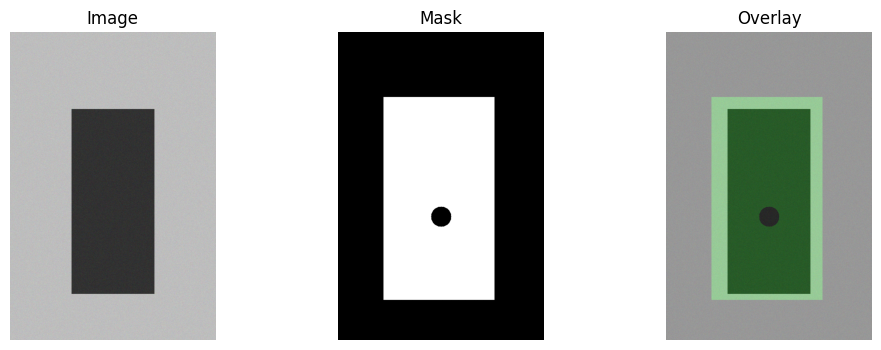

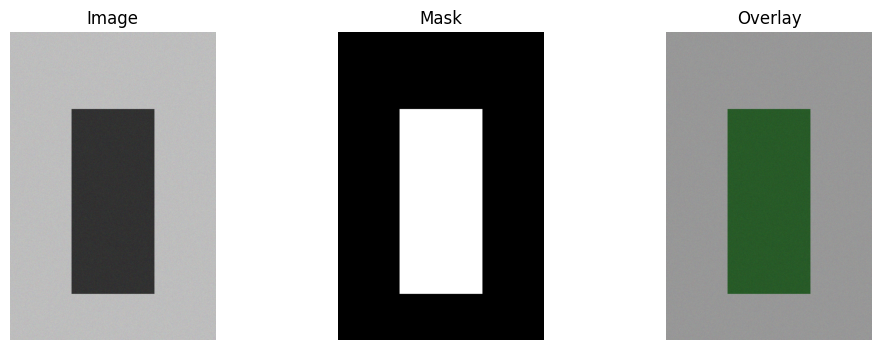

In [8]:
def overlay_mask(img, mask):
    mask_col = np.zeros_like(img)
    mask_col[:,:,1] = mask
    return cv2.addWeighted(img, 0.8, mask_col, 0.2, 0)

def show_sample(idx):
    row = labels.iloc[idx]
    img = cv2.imread(str(img_dir / row["image"]))
    mask = cv2.imread(str(mask_dir / row["mask"]), cv2.IMREAD_GRAYSCALE)
    over = overlay_mask(img, mask)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Mask"); plt.imshow(mask, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(cv2.cvtColor(over, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.show()

show_sample(6)   # kötü maske örneği
show_sample(8)   # etiket eksik örneği


# Sonuç Raporu

Bu çalışma kapsamında gerçek veri seti olmadan mini bir örnek veri seti oluşturularak etiket ve maske kalitesi değerlendirilmiştir.

Görsel kalite analizinde düşük çözünürlüklü, aşırı karanlık/parlak ve bulanık örnekler tespit edilmiştir. 
Bu tür görseller modelin öğrenmesini olumsuz etkileyebileceğinden eğitim öncesinde elenmesi veya iyileştirilmesi önerilir.

Etiket incelemesinde eksik etiketli örnekler ve sınıf isimlerinde tutarsızlıklar görülmüştür. 
Etiketlerin standartlaştırılması ve kontrol edilmesi veri seti kalitesini artıracaktır.

Maske değerlendirmesinde bazı maskelerde taşma ve kopukluk gibi problemler gözlemlenmiştir. 
Segmentasyon performansının artması için hatalı maskelerin düzeltilmesi veya yeniden anotasyon yapılması gerekmektedir.
